# MIS 284N Text Analysis Assignment 2

*Siqi Chen, Joshua Larky, Jiayan Lu, Jinru Su, Korawat Tanwisuth*

In [1]:
import pandas as pd
import operator
from itertools import combinations
from sklearn import manifold
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import urllib2
import re
%matplotlib inline

### Crawler

In [2]:
base_url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p"
pattern = re.compile("href=\"/profile/.*?\" class=\"Username\">(.*?)</a>.*?datetime=.*?>(.*?)</time>.*?class=\"Message\">(.*?)</div>", re.S)

In [3]:
userid = []
date = []
msg = []
for i in range(1, 200):
    request = urllib2.Request(base_url+str(i))
    response = urllib2.urlopen(request)
    page = response.read()
    result = re.findall(pattern, page)
    for j in range(len(result)):
        userid.append(result[j][0])
        date.append(result[j][1])
        msg.append(result[j][2])

In [4]:
myinfo = pd.DataFrame({'ID': userid, 'date':date, 'msg':msg})
myinfo.to_csv("forum_msg.csv")

### Word Count

In [5]:
msg = pd.read_csv("forum_msg.csv", index_col = 0)
msg.msg = msg.msg.apply(lambda x: x.lstrip().lower())

In [6]:
brand_model = pd.read_excel("Cars make model list.xlsx", index_col=0, header=2).reset_index().drop('index', axis=1)

In [7]:
brand_model.Search = brand_model.Search.apply(lambda x: x.lower().encode('ascii', 'ignore').decode('ascii'))

In [8]:
# replace models with brands
def replace_model(s):
    return reduce(lambda x, y: x.replace(y, brand_dict[y]), brand_dict, s.decode('ascii', 'ignore').encode('ascii'))
brand_dict = dict(zip(brand_model.Search, brand_model.Replace))
msg.msg = msg.msg.apply(replace_model)

In [9]:
# Count brands
brand_list = brand_model.Replace.unique()
non_brand_word = ['car', 'problem','seat','sedan']
brand_list = [x for x in brand_list if x not in non_brand_word]
brand_count = {}
for b in brand_list:
    brand_count[b] = sum(msg['msg'].str.contains(b))

In [10]:
sorted(brand_count.items(), key=operator.itemgetter(1), reverse = True)[:10]

[(u'bmw', 1927),
 (u'toyota', 1714),
 (u'pontiac', 1140),
 (u'honda', 717),
 (u'acura', 693),
 (u'audi', 622),
 (u'nissan', 588),
 (u'infiniti', 524),
 (u'ford', 312),
 (u'subaru', 299)]

### Task A

In [11]:
top_brand_list = [x[0] for x in sorted(brand_count.items(), key=operator.itemgetter(1), reverse = True)[:10]]
lift_matrix = [[0 for x in range(len(top_brand_list))] for y in range(len(top_brand_list))]

In [12]:
for brands in combinations(range(len(top_brand_list)), 2):
    b0_mask = msg['msg'].str.contains(top_brand_list[brands[0]])
    b1_mask = msg['msg'].str.contains(top_brand_list[brands[1]])
    lift = len(msg)*1.0*sum(b0_mask & b1_mask)/sum(b0_mask) / sum(b1_mask)
    lift_matrix[brands[0]][brands[1]] = 1/lift
    lift_matrix[brands[1]][brands[0]] = 1/lift

In [13]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=1,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(lift_matrix).embedding_

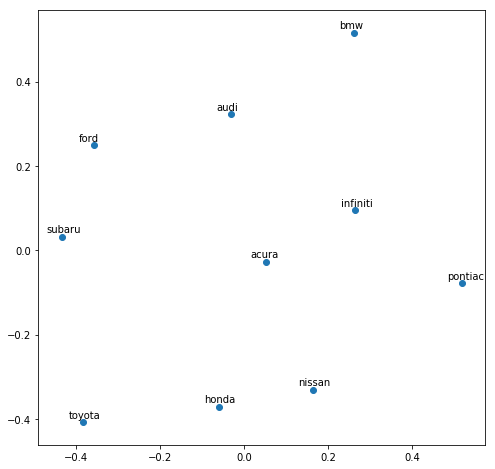

In [14]:
pos_x = [x[0] for x in pos]
pos_y = [x[1] for x in pos]
plt.figure(figsize=(8,8))
plt.scatter(pos_x, pos_y)
for i in range(len(top_brand_list)):
    plt.text(pos_x[i]-0.035, pos_y[i]+0.01, top_brand_list[i])
plt.show()

### Task B

To the Subaru brand manager:  As you can see from our graphic, Subaru is more closely mentioned in relation with Ford, than the other low-level Japanese brands (Toyota, Honda, and Nissan).  Since people are likely associating Subaru more with an American car company like Ford, it's important to recognize this, and decide if this is the direction we want Subaru to continue to take.  Association with American cars could broaden the overall appeal of Subaru in the market, but the cost is that American cars are known to be less reliable.  We need to decide if we are okay with this potential association, or if we want to change this.

To the Pontiac brand manager:  Pontiac is in a very unique position, where they are closest to Infiniti, yet nobody associates Pontiac with luxury.  We are afraid that because of Pontiac's less-than-stellar reputation, people may be using Pontiac as a low-level baseline vehicle.  People may be mentioning statements similar to: "I am now an Infiniti owner, and this car is much nicer and a smoother ride than my old Pontiac."

### Task C
By examining all the words appeared, we would examine following attributes followed by their similar words

<b>performance</b>: power, torque, sports, coupe, acceleration, steering, powerful

<b>comfort</b>: interior, seat, leather, sound, automatic

<b>reliability</b>: quality, warranty, maintenance, brake, brakes, braking

<b>luxury</b>: design, premium

<b>price</b>: expensive, cheap

In [15]:
def attr_replace(x):
    curr = x.replace("power", "performance")
    curr = curr.replace("torque", "performance")
    curr = curr.replace("sports", "performance")
    curr = curr.replace("coupe", "performance")
    curr = curr.replace("acceleration", "performance")
    curr = curr.replace("steering", "performance")
    curr = curr.replace("powerful", "performance")
    curr = curr.replace("interior", "comfort")
    curr = curr.replace("seat", "comfort")
    curr = curr.replace("leather", "comfort")
    curr = curr.replace("sound", "comfort")
    curr = curr.replace("automatic", "comfort")
    curr = curr.replace("quality", "reliability")
    curr = curr.replace("warranty", "reliability")
    curr = curr.replace("maintenance", "reliability")
    curr = curr.replace("brake", "reliability")
    curr = curr.replace("braking", "reliability")
    curr = curr.replace("brakes", "reliability")
    curr = curr.replace("design", "luxury")
    curr = curr.replace("premium", "luxury")
    curr = curr.replace("exterior", "luxury")
    curr = curr.replace("expensive", "price")
    curr = curr.replace("cheap", "price")
    return curr

In [16]:
attr_messages = msg.msg.apply(attr_replace)

In [17]:
attr_list = ['price', 'performance', 'comfort', 'reliability', 'luxury']
top5_brand = ['bmw', 'toyota', 'pontiac', 'honda', 'acura']

In [18]:
for b in top5_brand:
    max_lift = 0
    max_attr = ""
    print b.upper()
    for a in attr_list: 
        b_mask = attr_messages.str.contains(b)
        a_mask = attr_messages.str.contains(a)
        lift = len(attr_messages)*1.0*sum(b_mask & a_mask)/sum(b_mask)/sum(a_mask)
        print a,':', round(lift,2)
        if lift > max_lift:
            max_lift = lift
            max_attr = a
    print 'The attribute associated with', b, 'the most is', max_attr
    print 

BMW
price : 1.48
performance : 1.38
comfort : 1.34
reliability : 1.42
luxury : 1.27
The attribute associated with bmw the most is price

TOYOTA
price : 1.4
performance : 1.37
comfort : 1.38
reliability : 1.57
luxury : 1.28
The attribute associated with toyota the most is reliability

PONTIAC
price : 1.63
performance : 1.61
comfort : 1.46
reliability : 1.3
luxury : 1.26
The attribute associated with pontiac the most is price

HONDA
price : 1.58
performance : 1.42
comfort : 1.19
reliability : 1.61
luxury : 1.35
The attribute associated with honda the most is reliability

ACURA
price : 1.48
performance : 1.42
comfort : 1.31
reliability : 1.34
luxury : 1.39
The attribute associated with acura the most is price



BMW's entry-level luxury cars do not appear to be the ultimate driving machines.  Perhaps at a different price point, we would notice higher lift values for performance or reliability for BMW.  Looking at similarly priced Acuras, BMW actually has a lower lift value on performance, even though these two brands are often comparably priced.

### Task D

BMW product manager: We think it would be beneficial to improve performance of the car slightly so the lift value can increase even more.  Also, being more cost-efficient with inputs could help lower the price, since many people mentioned that BMW has a high price.

BMW Marketing manager: The next commercials on television should prominently display all the luxury features that BMWs have to offer at the entry-level luxury price point.  We want to improve on this low lift value.

Toyota product manager: We assume people think Toyotas are not reliable, and they talk about it a lot (high lift value).  For the next product models, it's important to make sure the car is safer and more reliable.  

Toyota Marketing manager: The lift value for luxury is very low, and we think it would be good to promote new high-tech features that future Toyotas have installed.

Pontiac product manager: There is a high lift value for performance, and we assume it's negative.  Future Pontiac cars should have better engines so that people can change their view of Pontiac.

Pontiac Marketing manager: Pontiac has a low reliability lift value.  In future commercials, highlighting how long Pontiacs can drive for between services may be important, or how safe and dependable they are.

Honda product manager: Honda probably needs to fix its seats, since people never associate Hondas with comfort.

Honda Marketing manager: People talk about price a lot, and we assume it's positive (Hondas are well-priced).  In the future, it's important to keep talking about this in advertisements, so people know that Honda is a low-cost alternative to many other entry-level luxury car brands.

Acura product manager: Acura does not have a very high comfort lift value, and we think that the interior of the car should be re-designed (maybe making the inside of it more spacious). 

Acura Marketing manager: Acura has a high association with luxury (assumed positive), but a high association with price (assumed negative).  We think it'd be beneficial in future commercials to highlight how luxurious the Acura is, so people can overcome the negativity they feel towards the price of it.

### Task E
To find the most aspirational brand, we calculate the lift between brands and some words expressing their positive sentiment such as 'want', 'love', 'like' and 'own'. With 'like' in the list, Mercury was the most "aspirational" brand in the list. However, we assumed this was partially due to people saying "do not like Mercury."  Our suspicion was confirmed when we removed 'like' from our list of words to count, and Mercury went from number 1 to the second to last position.

With an updated aspirational words list, Mitsubishi is apparently an aspirational car in the United States.  This is unexpected, but buried inside Edmunds.com is positive insight about this brand.  People may be attracted to this brand because the cars are less expensive than their competition.

In [19]:
pos_words = ['wish','good', 'best', 'great', 'nice','love',\
             'wanted', 'want', 'wants', 'prefer', 'own']

In [20]:
def aspiration_replace(x):
    curr = x
    for word in pos_words:
        curr = curr.replace(word, 'aspiration')
    return curr
aspiration_msg = msg.msg.apply(aspiration_replace)

In [21]:
pos_dict = {}
p_mask = aspiration_msg.str.contains('aspiration')
for b in brand_list:
    b_mask = aspiration_msg.str.contains(b)
    lift = (len(p_mask)*1.0*sum(b_mask & p_mask) + 1)/sum(b_mask)/sum(p_mask)
    pos_dict[b] = round(lift,2)

In [22]:
sorted(pos_dict.items(), key=operator.itemgetter(1), reverse = True)

[(u'mitsubishi', 1.54),
 (u'volkswagen', 1.42),
 (u'dodge', 1.42),
 (u'chrysler', 1.42),
 (u'suzuki', 1.38),
 (u'saturn', 1.38),
 (u'hyundai', 1.37),
 (u'mazda', 1.37),
 (u'ford', 1.35),
 (u'audi', 1.33),
 (u'volvo', 1.32),
 (u'chevrolet', 1.31),
 (u'honda', 1.3),
 (u'cadillac', 1.29),
 (u'toyota', 1.29),
 (u'infiniti', 1.27),
 (u'lincoln', 1.27),
 (u'buick', 1.26),
 (u'bmw', 1.24),
 (u'acura', 1.24),
 (u'nissan', 1.24),
 (u'subaru', 1.23),
 (u'mercedes', 1.22),
 (u'pontiac', 1.2),
 (u'mercury', 1.09),
 (u'kia', 1.04)]